<a href="https://colab.research.google.com/github/Capstone-Project-July/Interim/blob/master/Project_Capstone_EDA%2BPreprocessing_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns 
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from nltk.tokenize import TweetTokenizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import tensorflow as tf
from textblob import TextBlob
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from IPython.display import clear_output
from keras.models import Model 
from keras.layers import Embedding, Activation, SpatialDropout1D, Flatten, Dense, Input, LSTM, Bidirectional, Dropout, Conv1D, MaxPool1D, CuDNNLSTM, GlobalMaxPool1D
from keras.optimizers import RMSprop
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
#For stopwords and tokenisation
import string
from string import punctuation
from nltk.corpus import stopwords
from nltk import word_tokenize
from PIL import Image
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn import preprocessing #Changing categorical data to one hot encoding
from nltk.tokenize import RegexpTokenizer
from sklearn.cluster import KMeans
from nltk.stem import PorterStemmer
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances
from numpy import unique
from numpy import where
from sklearn.cluster import AffinityPropagation #Using this to best summarize the data
from matplotlib import pyplot 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## **Connecting the Notebook to Google Drive**

In [ ]:
from google.colab import drive

drive.mount('/content/drive')
#Loading the datafile
data =pd.read_excel('/content/drive/My Drive/Colab Notebooks/input_data.xlsx')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Exploratory data analysis**



1.   Understanding the attributes in the dataset
2.   Identifying the size of dataset
3.   Exploring the Target Attribute
4.   Using Different visualizations to understand the data



#### 1. Understanding the shape of dataset and attributes

In [ ]:
data.shape

(8500, 4)

In [ ]:
data.head(3)

,Short description,Description,Caller,Assignment group
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0


In [ ]:
data.dtypes

Short description    object
Description          object
Caller               object
Assignment group     object
dtype: object

#### Findings


1.   The data has 8500 data points
2.   The data has 4 Attributes
3.   Short Description has a brief about the issue and Description contains more details. 
4.   Description and Short Description have the same information. Description is just more detailed
4.   All attributes have the same datatype "Object"
5.   Assignment group is the target attribute
6.   The attribute column refers to the person who has raised the ticket

#### **Exploring the target attribute and visualizations**

In [ ]:
data['Assignment group'].value_counts()

GRP_0     3976
GRP_8      661
GRP_24     289
GRP_12     257
GRP_9      252
          ... 
GRP_64       1
GRP_35       1
GRP_61       1
GRP_70       1
GRP_73       1
Name: Assignment group, Length: 74, dtype: int64

#### Using count plot to understand the distribution of assignment groups

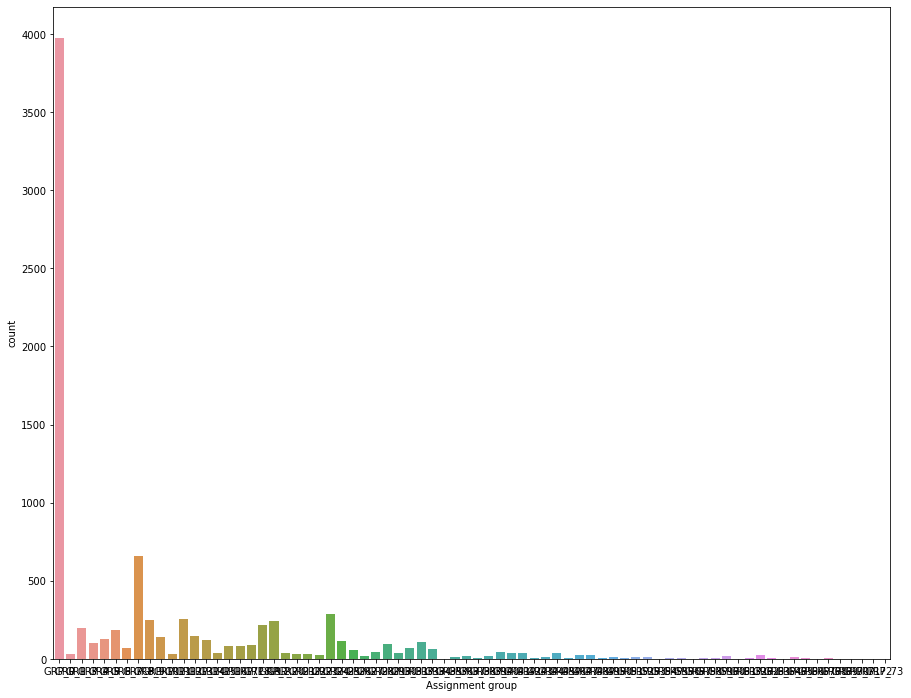

In [ ]:
plt.figure(figsize=(15,12))
sns.countplot(x="Assignment group", data=data) 


#### Dropping the assignment group with Maximum counts to understand the distribution of the rest of the data

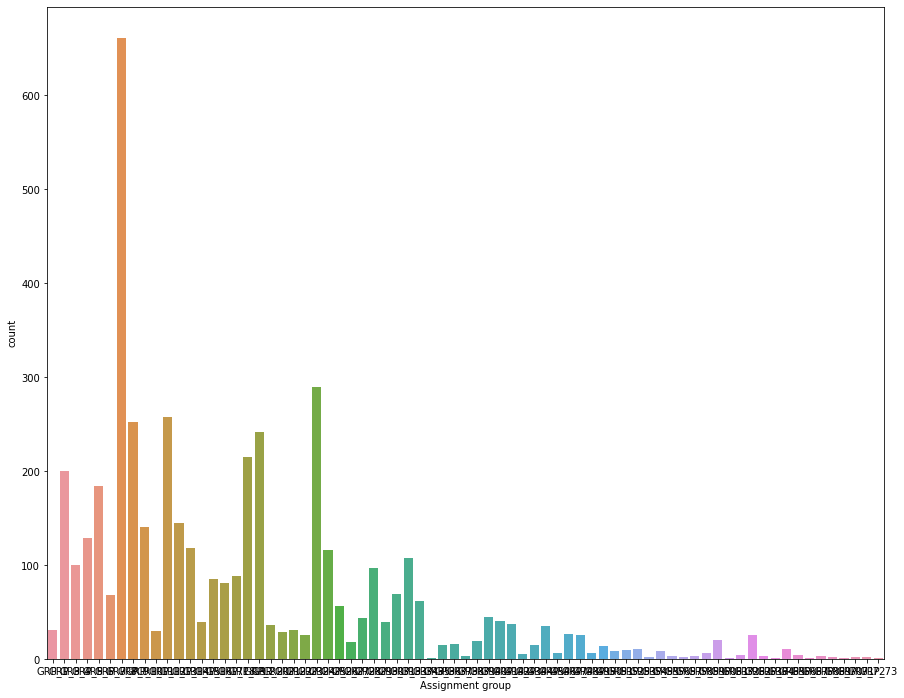

In [ ]:
count_plot=data.drop(data[data['Assignment group']=='GRP_0'] .index,axis=0)
plt.figure(figsize=(15,12))
sns.countplot(x="Assignment group", data=count_plot) 

#### Dropping the Assignment group with second highest count, to understand the spread of other groups

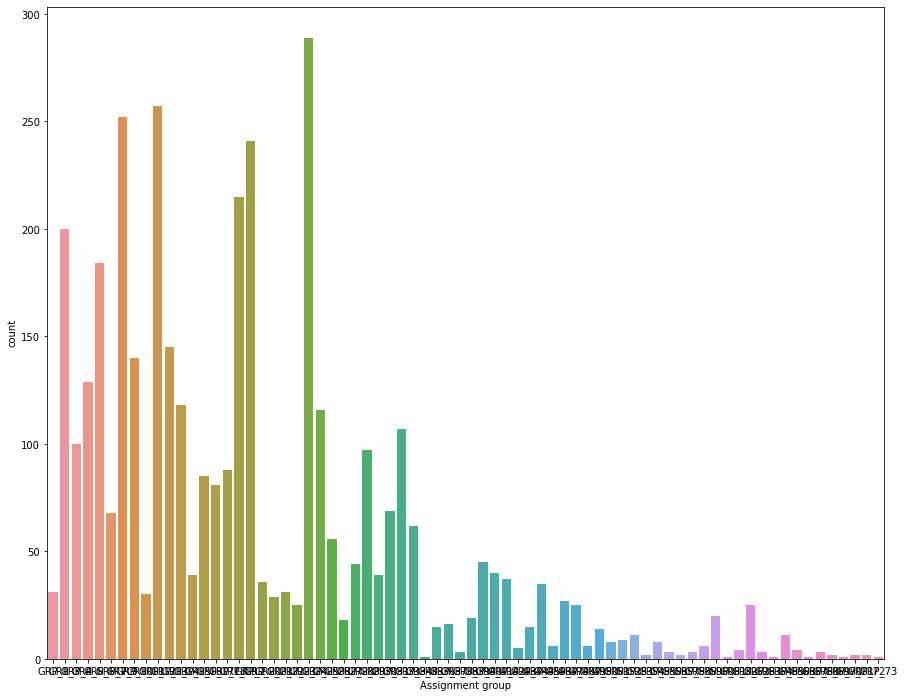

In [ ]:
count_plot=count_plot.drop(count_plot[count_plot['Assignment group']=='GRP_8'] .index,axis=0)
plt.figure(figsize=(15,12))
sns.countplot(x="Assignment group", data=count_plot) 

#### Visualizing using Pi Chart

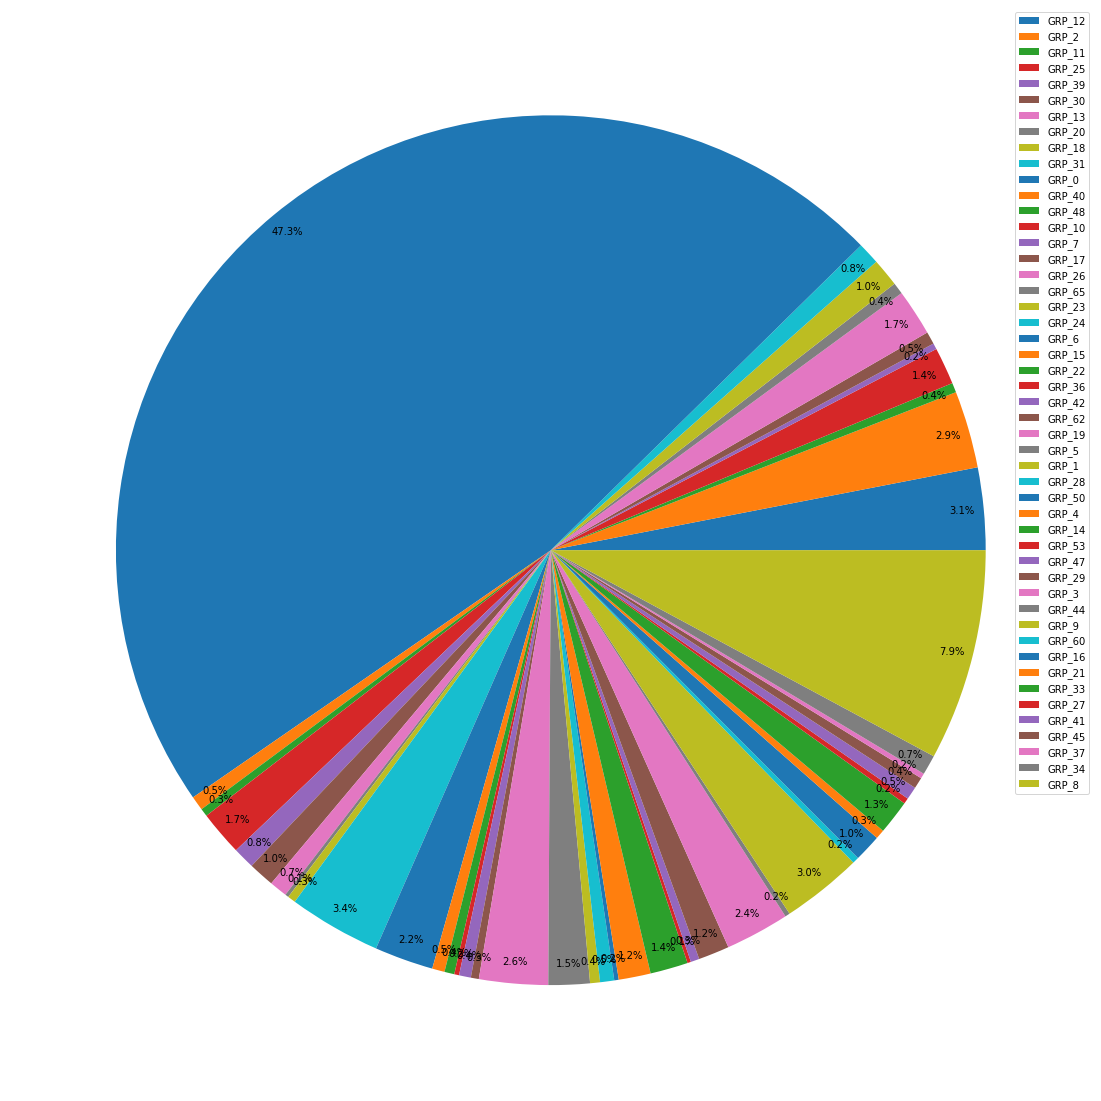

In [ ]:
# Creating a Dataframe to visualize Pi chart and Word Clouds
pi=pd.DataFrame()
groups=list(set(data['Assignment group'].values))
count=[]
for gr in groups:
  count.append(data[data['Assignment group']==gr].shape[0])
pi['Group']=groups
pi['Counts']=count
pi['Group']=pi['Group'].astype('object')
pi.drop(pi[pi['Counts']<10].index,axis=0,inplace=True)
pi.head()
plt.figure(figsize=(20,20))
plt.pie(pi['Counts'],autopct='%1.1f%%',pctdistance=0.95)
plt.legend(loc='upper right',labels=pi['Group'])
plt.show()

#### Findings


1.  GRP_0 has the highest number of data points and the data is biased(47.3%) of total data 
2.  GRP_8 has the second highest number of data points(7.9% of total data)
3.  There are certain Assignment groups which have single entry, and hence they might not be useful for further analysis
4.  The dataset is not balanced



# **Data Preprocessing**

#### Handling the NaN values in Short Description and Description

In [ ]:
data1 = pd.isnull(data["Short description"])
data[data1]

,Short description,Description,Caller,Assignment group
2604,NaN,\r\n\r\nreceived from: ohdrnswl.rezuibdt@gmail...,ohdrnswl rezuibdt,GRP_34
3383,NaN,\r\n-connected to the user system using teamvi...,qftpazns fxpnytmk,GRP_0
3906,NaN,-user unable tologin to vpn.\r\n-connected to...,awpcmsey ctdiuqwe,GRP_0
3910,NaN,-user unable tologin to vpn.\r\n-connected to...,rhwsmefo tvphyura,GRP_0
3915,NaN,-user unable tologin to vpn.\r\n-connected to...,hxripljo efzounig,GRP_0
3921,NaN,-user unable tologin to vpn.\r\n-connected to...,cziadygo veiosxby,GRP_0
3924,NaN,name:wvqgbdhm fwchqjor\nlanguage:\nbrowser:mic...,wvqgbdhm fwchqjor,GRP_0
4341,NaN,\r\n\r\nreceived from: eqmuniov.ehxkcbgj@gmail...,eqmuniov ehxkcbgj,GRP_0


In [ ]:
data2 = pd.isnull(data["Description"]) 
data[data2]

,Short description,Description,Caller,Assignment group
4395,i am locked out of skype,NaN,viyglzfo ajtfzpkb,GRP_0


#### There are 8 NaN values in Short Description and 1 NaN values in Description.
##### Inorder to handle this, as both Short Description and Description has similar data, we are replacing the NaN values in Short Description with corresponding values in Description and Vice Versa

In [ ]:
#Replacing NaN with corresponding value in Description

nalist=data[data['Short description'].isna()].index.values 
data['Short description'][nalist]='NAN'

for i in nalist:
    data['Short description'][i]=data['Short description'][i].replace('NAN',data['Description'][i])

#Replacing Nan values with corresponding value of Short Description
 
nalist1=data[data['Description'].isna()].index.values

data['Description'][nalist1]='NAN'

for i in nalist1:
    data['Description'][i]=data['Description'][i].replace('NAN',data['Short description'][i])

#### Dropping the rows where the Assignment group is blank

In [ ]:
groups=data['Assignment group']
data.dropna(inplace=True) #Dropping null values

#### Using label encoder to encode the Assignment group column

In [ ]:
le = preprocessing.LabelEncoder() 
le.fit(data['Assignment group'])
data['Assignment group Encoded'] = le.transform(data['Assignment group'])

## The following observations can be inferred from the plots



1.   The dataset is biased with around 47.3%(3976 entries) of data belonging to Assignment Group 0
2.   Keeping aside Group 0, Group 72 has the second highest count with 7.9% (661 entries)



#### Removing rows with Assignment groups which doesnt occur more than 50 times

In [ ]:
vc=data['Assignment group'].value_counts()
to_remove = vc[vc <= 50].index
to_remove=data[data['Assignment group'].isin(to_remove)].index
data.drop(to_remove, axis=0,inplace=True)
data.shape

(7736, 5)

#### Using count plot to understand the distribution of assignment groups after deletion

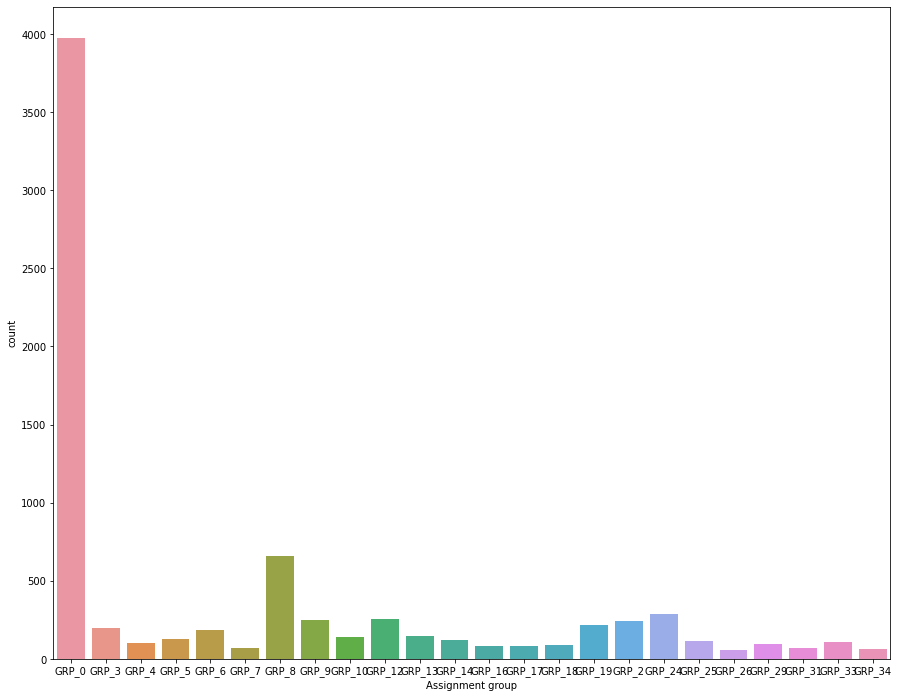

In [ ]:
plt.figure(figsize=(15,12))
sns.countplot(x="Assignment group", data=data) 


#### Dropping the assignment group with Maximum counts to understand the distribution of the rest of the data

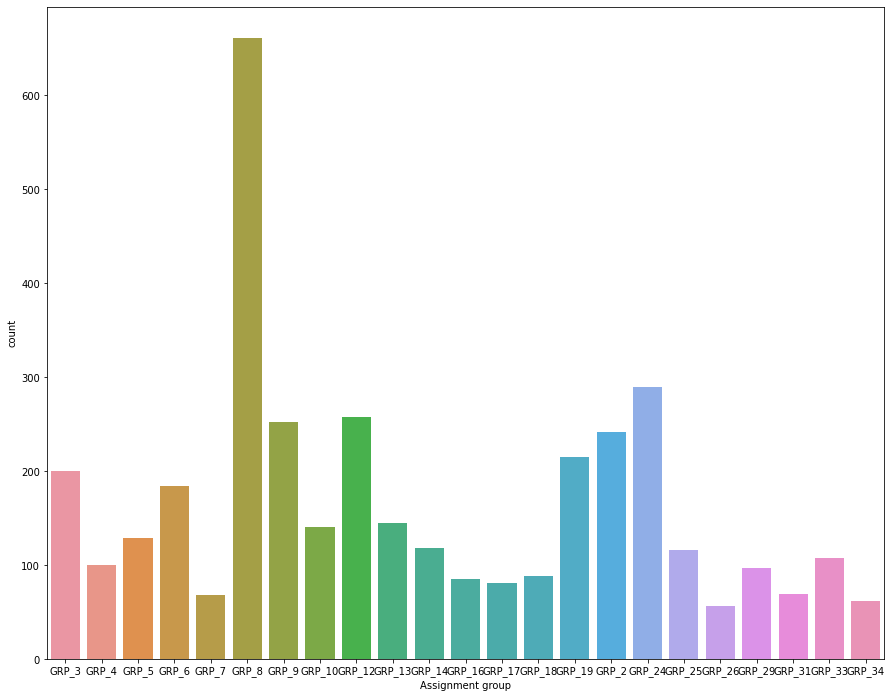

In [ ]:
count_plot=data.drop(data[data['Assignment group']=='GRP_0'] .index,axis=0)
plt.figure(figsize=(15,12))
sns.countplot(x="Assignment group", data=count_plot) 

#### Dropping the Assignment group with second highest count, to understand the spread of other groups

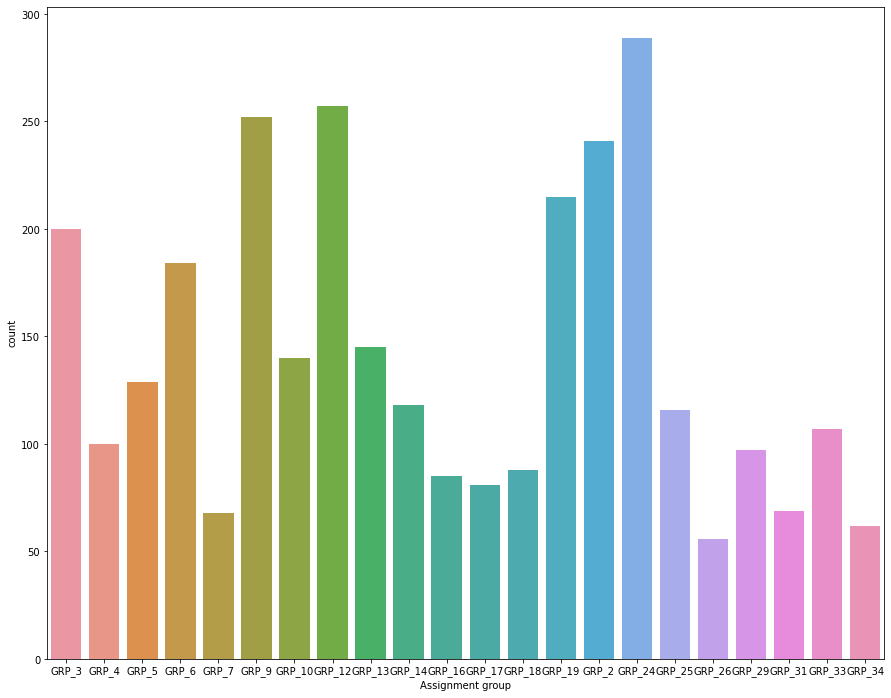

In [ ]:
count_plot=count_plot.drop(count_plot[count_plot['Assignment group']=='GRP_8'] .index,axis=0)
plt.figure(figsize=(15,12))
sns.countplot(x="Assignment group", data=count_plot) 

#### Visualizing using Pi Chart

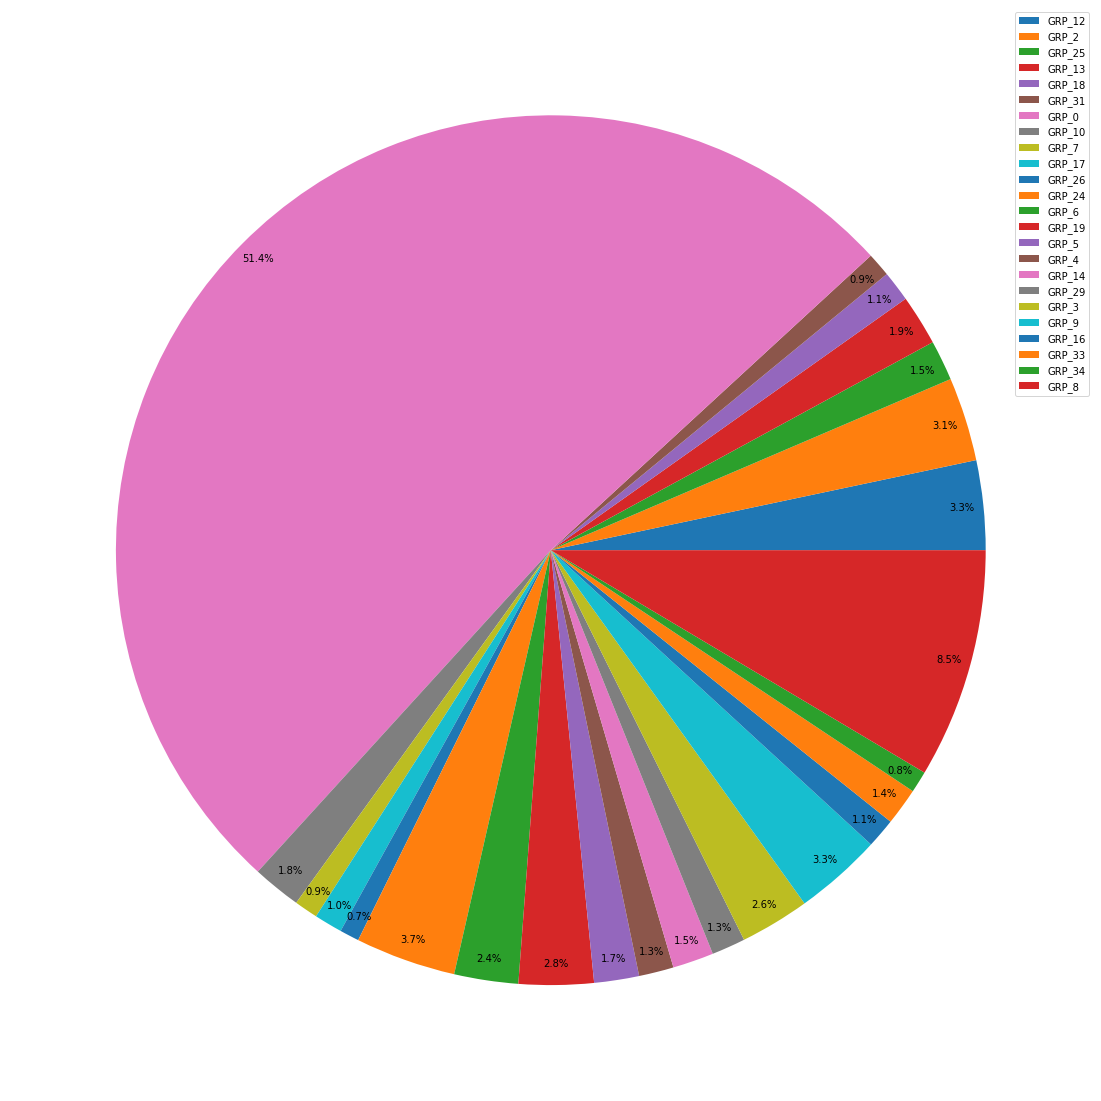

In [ ]:
# Creating a Dataframe to visualize Pi chart and Word Clouds
pi=pd.DataFrame()
groups=list(set(data['Assignment group'].values))
count=[]
for gr in groups:
  count.append(data[data['Assignment group']==gr].shape[0])
pi['Group']=groups
pi['Counts']=count
pi['Group']=pi['Group'].astype('object')
pi.drop(pi[pi['Counts']<10].index,axis=0,inplace=True)
pi.head()
plt.figure(figsize=(20,20))
plt.pie(pi['Counts'],autopct='%1.1f%%',pctdistance=0.95)
plt.legend(loc='upper right',labels=pi['Group'])
plt.show()

## Word Clouds

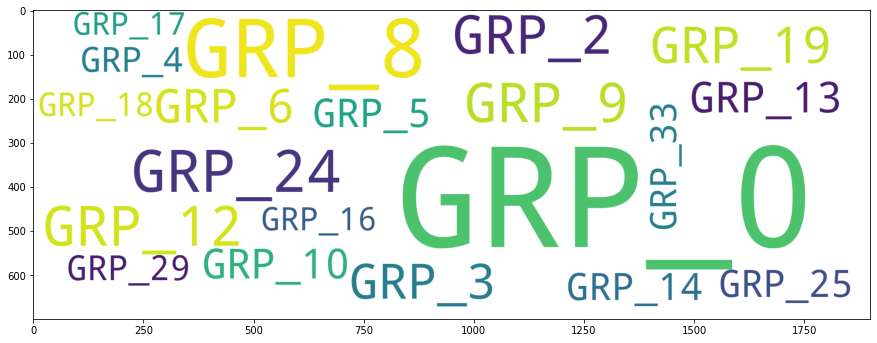

In [ ]:
d={u:v for u,v in zip(pi['Group'],pi['Counts'])}

cloud = WordCloud(width=1900,height=700,background_color = "white", max_words = 20).generate_from_frequencies(d)
plt.figure(figsize=(15,15))
plt.imshow(cloud)

#### Dropping the caller column

In [ ]:
data.drop(['Caller'],axis=1,inplace=True)

#### Using label encoder to encode the Assignment group column

In [ ]:
le = preprocessing.LabelEncoder() 
le.fit(data['Assignment group'])
data['Assignment group'] = le.transform(data['Assignment group'])
data.head()

,Short description,Description,Assignment group,Assignment group Encoded
0,login issue,-verified user details.(employee# & manager na...,0,0
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,0,0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,0,0
3,unable to access hr_tool page,unable to access hr_tool page,0,0
4,skype error,skype error,0,0


#### Tokenizing function definition

In [ ]:
others=['1','2','3','4','5','6','7','8','9','0','hi','resolved','hello','/']
stop_words=stopwords.words('english')+list(punctuation)+list(others)

def tokenize(text):
    words=word_tokenize(text)
    words=[w.lower() for w in words]
    words=[w for w in words if w not in stop_words and not w.isdigit()]
    return words

def tweet_tokens(text):
    tweet_tokens=TweetTokenizer()
    words=tweet_tokens.tokenize(text)
    words=[w.lower() for w in words]
    words=[w for w in words if w not in stop_words and not w.isdigit()]
    return words

#### Removing the Email ID from the Description

In [ ]:
for i in range(data.shape[0]):
    try:
      if len(re.findall('\S+@\S+', data['Description'][i]))>0:
        email=re.findall('\S+@\S+', data['Description'][i])[0]
        data['Description'][i]=data['Description'][i].replace(email,'')
    except:
      pass # As wwe have deleted some indexes earlier, we will get errors while processing those rows

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


#### Removing invalid charachters


In [ ]:
for i,row in data.iterrows():
  text=re.findall('[^A-Za-z]',row['Description'])
  for i in text:
    row['Description']=row['Description'].replace(i,' ')
  

In [ ]:
for i,row in data.iterrows():
  text=re.findall('[^A-Za-z]',row['Short description'])
  for i in text:
    row['Short description']=row['Short description'].replace(i,' ')
  

#### Converting to lower and Stemming

In [ ]:
for i,row in data.iterrows():
    row['Description']=row['Description'].lower()
    row['Short description']=row['Short description'].lower()

### Tokenising Short Description and Description and combining it into a single column

In [ ]:
common_words=['please','help','problem','resolve','issue','kindly','regards','thanks','kind','somebody','etc']

In [ ]:
token=[]
stem=PorterStemmer()
for i,row in data.iterrows():
    text=row['Short description']
    text1=row['Description']
    for p in punctuation:
        text=text.replace(p,' ')
        text1=text1.replace(p,' ')
    tok1=list(set(tokenize(text)))
    tok2=list(set(tokenize(text1)))
    tok1+=tok2
    string=[]
    
    tok3=[]
    for t in tok1:
      if t not in common_words:
        tok3.append(t)
    for i in nltk.pos_tag(tok3): 
        if (i[1]=='NN') | (i[1]=='NNS'):
            string.append(i[0])
    for i in range(len(string)):
      string[i]=string[i].replace(string[i],stem.stem(string[i]))
      
    token.append(list(set(string)))
    
data['Tokens']=token

#### Trying tokenization with Tweet Tokenizer

In [ ]:
token=[]
for i,row in data.iterrows():
    text=row['Short description']
    text1=row['Description']
    for p in punctuation:
        text=text.replace(p,' ')
        text1=text1.replace(p,' ')
    tok1=list(set(tweet_tokens(text)))
    tok2=list(set(tweet_tokens(text1)))
    tok1+=tok2
    string=[]
    tok3=[]
    for t in tok1:
      if t not in common_words:
        tok3.append(t)
    for i in nltk.pos_tag(tok3): 
        if (i[1]=='NN') | (i[1]=='NNS'):
            string.append(i[0])
    stem=PorterStemmer()
    
    for i in range(len(string)):
      string[i]=string[i].replace(string[i],stem.stem(string[i]))

    token.append(list(set(string)))
    
data['Tweet Tokens']=token

In [ ]:
data.head()

,Short description,Description,Assignment group,Assignment group Encoded,Tokens,Tweet Tokens
0,login issue,-verified user details.(employee# & manager na...,0,0,"[login, ad, user, reset, caller, manag, employ...","[login, ad, user, reset, caller, manag, employ..."
1,outlook,"\r\n\r\nreceived from: \r\n\r\nhello team,\r\n...",0,0,"[meet, team, outlook, calendar, skype, advis]","[meet, team, outlook, calendar, skype, advis]"
2,cant log in to vpn,\r\n\r\nreceived from: \r\n\r\nhi\r\n\r\ni can...,0,0,"[vpn, cant, log]","[vpn, cant, cannot, log]"
3,unable to access hr_tool page,unable to access hr_tool page,0,0,"[access, tool, hr, page]","[access, tool, hr, page]"
4,skype error,skype error,0,0,"[error, skype]","[error, skype]"


#### Findings


1.  GRP_0 still has the highest number of data points and the data is biased(51.4%) of total data 
2.  GRP_8 has the second highest number of data points(8.5% of total data)
3.  There are certain Assignment groups which have less than 50 data points and they have been removed and now we have a more clean dataset. Inorder to consider them for prediction, we will need more data
4.  Caller column has been dropped as it was not having relevant information
5.  Email ID's, Invalid Charachters, etc has bee removed from the description and Short Description
6. Words which are not Nouns are removed as they are found to be non-technical words and it helps to give more precise tokens
7.  Out of Tweet Tokenizer and Normal Tokenizer, both seems to be giving similar results. Tweet Tokenizer is ibserved to be finding better results when invalid charachters are present along with words. Hence we are using Tweet Tokenizer will be used for further analysis. 
8.  Rows with zero tokens have also been dropped as it doesnt provide any useful information



# **Creating a Word2Vec vector**

#### Dropping rows with Blanks Tokens

In [ ]:
drop_index=[]
for i,rows in data.iterrows():
  if len(rows['Tweet Tokens'])<1:
    drop_index.append(i)
    data.drop(i,axis=0,inplace=True)


#### Creating a Vocabulary

In [ ]:
vocabulary=set()
for i,row in data.iterrows():
    vocabulary.update(row['Tweet Tokens'])

vocabulary=list(vocabulary)

In [ ]:
word_index={w:index for index,w in enumerate(vocabulary)}

In [ ]:
vocab_size=len(vocabulary)
document_size=data.shape[0]

In [ ]:
word_idf=np.zeros(vocab_size)

for i,row in data.iterrows():
    words=row['Tweet Tokens']
    indexes=[word_index[w] for w in words]
    word_idf[indexes]+=1

In [ ]:
word_IDF=np.log(document_size/(1+word_idf).astype(float))

#### Functions for Word Term Frequency and TFIIDF

In [ ]:
def word_tf(word,document):
    return float(document.count(word))/len(document)

def tf_idf(word,document):
    
    if word not in word_index:
        return 0
    return word_tf(word,document)*word_IDF[word_index[word]]

In [ ]:
print(tf_idf('ticket',data['Tweet Tokens'][1589]))

0.8955954769368983


## Creating TFIDF Vector

In [ ]:
tf_vector=np.zeros((data.shape[0],len(vocabulary)))

In [ ]:
count=0
exception=[]
for i,row in data.iterrows():
    for j in range(len(vocabulary)):
        try:
          tf_vector[count,j]=tf_idf(vocabulary[j],row['Tweet Tokens'])
        except:
          exception.append(i)
    clear_output(wait=False)
    print(i)
    count+=1
    
        

8497


In [ ]:
data.drop(list(set(exception)),axis=0,inplace=True)

#### Saving the TFIDF Vector to save computation time later

In [ ]:
np.save('/content/drive/My Drive/Colab Notebooks/tfidf.npy',tf_vector)

In [ ]:
tfidf=np.load('/content/drive/My Drive/Colab Notebooks/tfidf.npy')

#### Kmeans clustering to create a sub-segment within the dataset

In [ ]:
from sklearn.cluster import KMeans

KM=KMeans(n_clusters=3,random_state=1)

KM.fit(tfidf)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=1, tol=0.0001, verbose=0)

In [ ]:
lab=KM.labels_

In [ ]:
data['Cluster']=lab

In [ ]:
lab.shape

(7724,)

#### Understanding the new clusters

#### Understanding Cluster 1

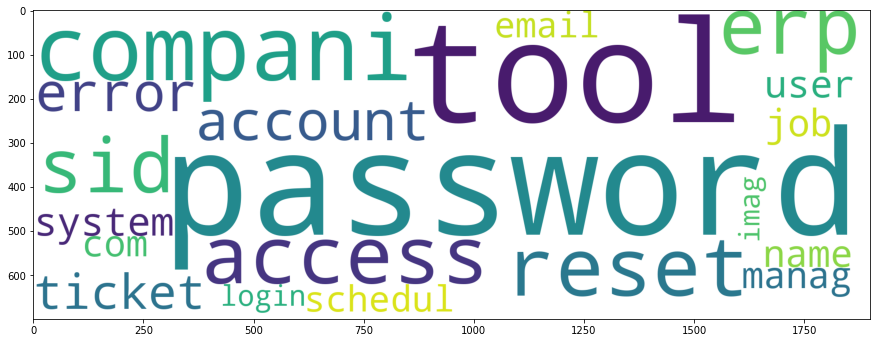

In [ ]:
word=[]
for i,rows in data[data['Cluster']==0].iterrows():
  for j in rows['Tweet Tokens']:
    word.append(j)
word_f=pd.DataFrame()
word_f['Words']=word
cluster_1=pd.DataFrame(word_f['Words'].value_counts())
cluster_1=cluster_1.reset_index()
d={u:v for u,v in zip(cluster_1['index'],cluster_1['Words'])}

cloud = WordCloud(width=1900,height=700,background_color = "white", max_words = 20).generate_from_frequencies(d)
plt.figure(figsize=(15,15))
plt.imshow(cloud)

#### Understanding Cluster 2


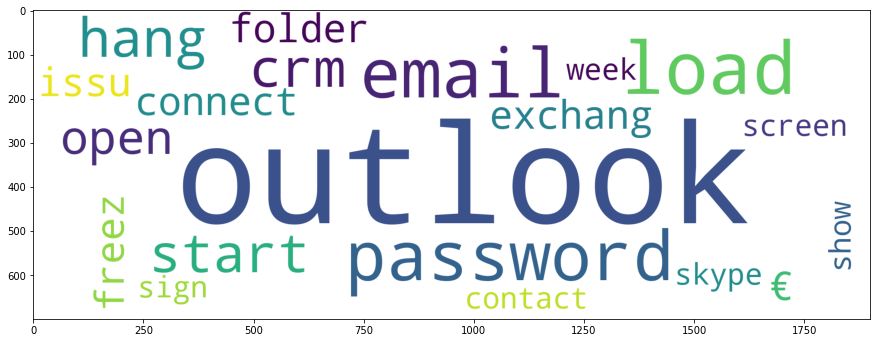

In [ ]:
word=[]
for i,rows in data[data['Cluster']==1].iterrows():
  for j in rows['Tweet Tokens']:
    word.append(j)
word_f=pd.DataFrame()
word_f['Words']=word
cluster_2=pd.DataFrame(word_f['Words'].value_counts())
cluster_2=cluster_2.reset_index()
d={u:v for u,v in zip(cluster_2['index'],cluster_2['Words'])}

cloud = WordCloud(width=1900,height=700,background_color = "white", max_words = 20).generate_from_frequencies(d)
plt.figure(figsize=(15,15))
plt.imshow(cloud)

#### Understanding cluster 3

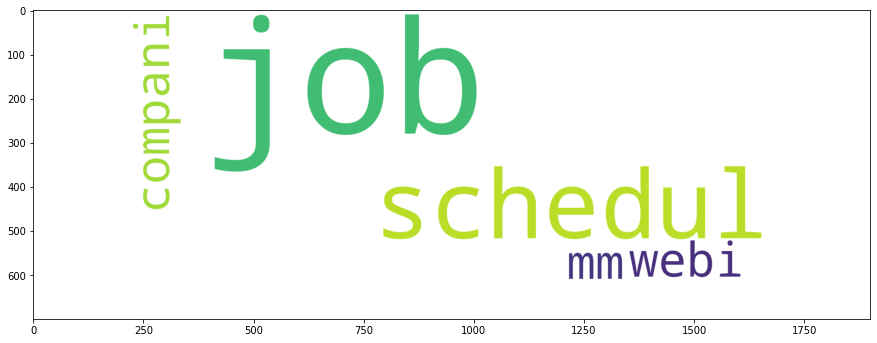

In [ ]:
word=[]
for i,rows in data[data['Cluster']==2].iterrows():
  for j in rows['Tweet Tokens']:
    word.append(j)
word_f=pd.DataFrame()
word_f['Words']=word
cluster_3=pd.DataFrame(word_f['Words'].value_counts())
cluster_3=cluster_3.reset_index()
d={u:v for u,v in zip(cluster_3['index'],cluster_3['Words'])}

cloud = WordCloud(width=1900,height=700,background_color = "white", max_words = 20).generate_from_frequencies(d)
plt.figure(figsize=(15,15))
plt.imshow(cloud)

#### **Understanding the clusters**
1. Cluster 1, is foscussed with issues related to Job Scheduler, Payroll, Hostnames, HR etc


2.  Cluster 2 is more focussed with issus related to Accounts, Windows, ERP, Password, Ad, etc

3.  Cluster 3 is a more generic group with generic issues. It has issues related to Password, Tools, Access, Phone, Network Login etc




#### Saving the preprocessed file for further processing

In [ ]:
tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word' , stop_words= 'english') 
features = tfidf.fit_transform(data['Description'].values)
data['features']=features


#### **To understand if TFIDF Vectorizer can be used as an alternative for the above preprocessing steps**

>  We are implementing a similar kmeans slustering using the TFIDFVectorizer features
>  We will be checking how similar are the created clusters

In [ ]:
from sklearn.cluster import KMeans
np.random.seed(30)

KMean= KMeans(n_clusters=3).fit(features)
lab1=KMean.predict(tfidf.transform(data['Description']))
data['Cluster TFIDFV']=lab1

#### Understanding the new clusters

#### Understanding Cluster 1

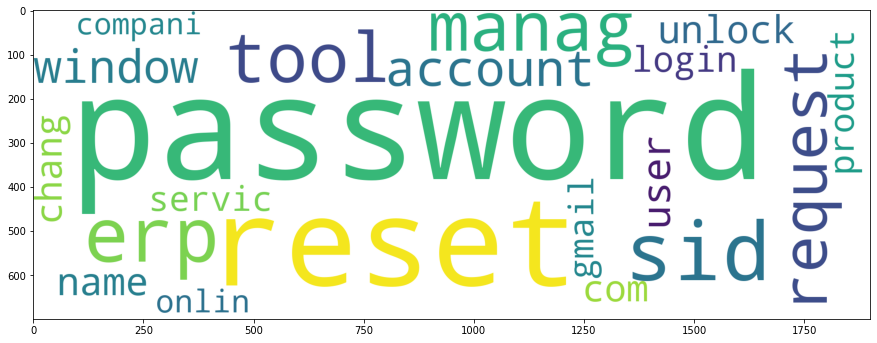

In [ ]:
word=[]
for i,rows in data[data['Cluster TFIDFV']==0].iterrows():
  for j in rows['Tweet Tokens']:
    word.append(j)
word_f=pd.DataFrame()
word_f['Words']=word
cluster_1=pd.DataFrame(word_f['Words'].value_counts())
cluster_1=cluster_1.reset_index()
d={u:v for u,v in zip(cluster_1['index'],cluster_1['Words'])}

cloud = WordCloud(width=1900,height=700,background_color = "white", max_words = 20).generate_from_frequencies(d)
plt.figure(figsize=(15,15))
plt.imshow(cloud)

#### Understanding Cluster 2


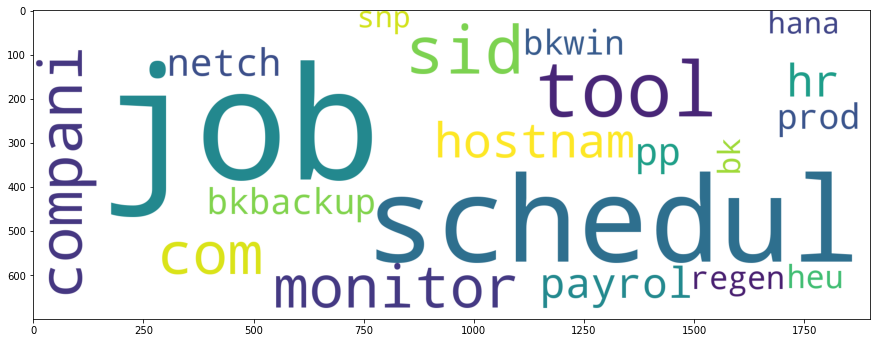

In [ ]:
word=[]
for i,rows in data[data['Cluster TFIDFV']==1].iterrows():
  for j in rows['Tweet Tokens']:
    word.append(j)
word_f=pd.DataFrame()
word_f['Words']=word
cluster_2=pd.DataFrame(word_f['Words'].value_counts())
cluster_2=cluster_2.reset_index()
d={u:v for u,v in zip(cluster_2['index'],cluster_2['Words'])}

cloud = WordCloud(width=1900,height=700,background_color = "white", max_words = 20).generate_from_frequencies(d)
plt.figure(figsize=(15,15))
plt.imshow(cloud)

#### Understanding cluster 3

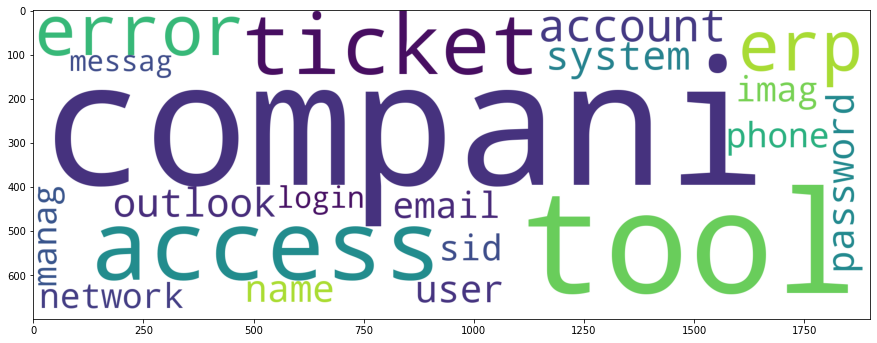

In [ ]:
word=[]
for i,rows in data[data['Cluster TFIDFV']==2].iterrows():
  for j in rows['Tweet Tokens']:
    word.append(j)
word_f=pd.DataFrame()
word_f['Words']=word
cluster_3=pd.DataFrame(word_f['Words'].value_counts())
cluster_3=cluster_3.reset_index()
d={u:v for u,v in zip(cluster_3['index'],cluster_3['Words'])}

cloud = WordCloud(width=1900,height=700,background_color = "white", max_words = 20).generate_from_frequencies(d)
plt.figure(figsize=(15,15))
plt.imshow(cloud)

#### **Understanding the clusters**
1. Cluster 1, is foscussed with issues related to Password, Reset, ERP,Login , Account, Windows related issues


2.  Cluster 2 is more focussed with issus related to Job Scheduler, Hostnames, Payrolls, Backups, phones etc

3.  Cluster 3 is a more generic group with generic issues. It has issues related to Password, Tools, Access, Phone, Network Login etc




# **Analysis of two approaches**
> Both the apporach seems to be creating clusters of clusters with similar keywwords.

> The cluster numbers are different , bt the content of the clusters are similar


In [132]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7724 entries, 0 to 8497
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Short description         7724 non-null   object
 1   Description               7724 non-null   object
 2   Assignment group          7724 non-null   int64 
 3   Assignment group Encoded  7724 non-null   int64 
 4   Tokens                    7724 non-null   object
 5   Tweet Tokens              7724 non-null   object
 6   Cluster                   7724 non-null   int32 
 7   features                  7724 non-null   object
 8   Cluster TFIDFV            7724 non-null   int32 
dtypes: int32(2), int64(2), object(5)
memory usage: 543.1+ KB


#### Saving the preprocessed file for further processing

In [ ]:
data.to_excel('/content/drive/My Drive/Colab Notebooks/Preprocessed_input_data_.xlsx')

In [138]:
data.to_csv('/content/drive/My Drive/Colab Notebooks/Preprocessed_input_data_.csv')